<a href="https://colab.research.google.com/github/dozetype/pytorch-notes/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [664]:
from sklearn.datasets import make_circles

n_samples = 1000

#create circles

X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [665]:
print("Generates 1000 dots either R or B \n", X.shape, y[:10])

Generates 1000 dots either R or B 
 (1000, 2) [1 1 1 1 0 1 1 1 1 0]


In [666]:
import pandas as pd

df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "class": y})
df.head(10)

,x,y,class
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


Text(0.5, 1.0, 'make_circles dataset')

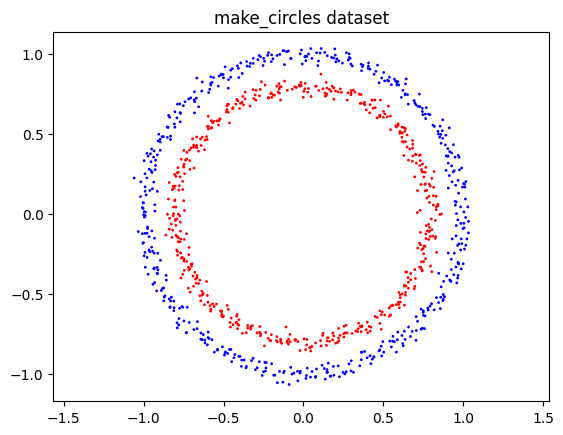

In [667]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=1) # x, y, class, classColours, size of point
plt.axis('equal')
plt.title("make_circles dataset")
# # plt.show()

In [668]:
import torch
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()
X_tensor[:5], y_tensor[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [669]:
type(X_tensor), X_tensor.dtype, y_tensor.dtype

(torch.Tensor, torch.float32, torch.float32)

In [670]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(800, 200)

# Building Model

In [671]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [672]:
# Using custom model
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=8)
        self.layer2 = nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

model0 = ModelV0().to(device) # Move all params into gpu
print(model0)




# Using Sequential
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)
print(model0)

ModelV0(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)


In [673]:
next(model0.parameters()).device # only check first param

device(type='cpu')

In [674]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0257,  0.6894],
                      [-0.2177, -0.2229],
                      [ 0.4266, -0.2600],
                      [-0.0607,  0.6603],
                      [-0.2899, -0.5059],
                      [-0.3957, -0.1960],
                      [-0.3355, -0.3669],
                      [ 0.2856,  0.1202]])),
             ('0.bias',
              tensor([-0.2263, -0.5494, -0.2226, -0.2984, -0.2301, -0.6379,  0.1523, -0.5195])),
             ('1.weight',
              tensor([[-0.2753, -0.2889,  0.1476, -0.2128, -0.1459,  0.2771,  0.1877,  0.2027]])),
             ('1.bias', tensor([-0.3357]))])

# LOSS & OPTIMIZERS

In [675]:
loss_fn = nn.BCEWithLogitsLoss() # bc BCELoss is used for binary classification, and with logits help to apply sigmoid as data currently not [0 to 1]
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [676]:
def accuracy_fn(y_ans, y_preds):
    correct = torch.eq(y_ans, y_preds).sum().item()
    acc = (correct / len(y_ans)) * 100
    return acc

# Just converting around

In [677]:
model0.eval()
with torch.inference_mode():
    y_preds = model0(X_test.to(device))
y_preds[:5], y_test[:5] # Not Good, as its not sigmoid, so it doesnt have much meaning(no probability)

(tensor([[-0.5510],
         [-0.6193],
         [-0.2419],
         [-0.6392],
         [-0.0351]]),
 tensor([1., 0., 1., 0., 1.]))

In [678]:
y_preds_sigmoid = torch.sigmoid(y_preds)
y_preds_sigmoid[:5], y_preds_sigmoid[:5].round() # Now there is meaning

(tensor([[0.3656],
         [0.3500],
         [0.4398],
         [0.3454],
         [0.4912]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [679]:
# Answer
y_preds = y_preds_sigmoid.round()

# Full process | Logits -> Probability -> Label
y_labels = torch.round(torch.sigmoid(model0(X_test.to(device))))

# Check Answer
print(torch.eq(y_labels.squeeze(), y_preds.squeeze()).sum(), len(y_labels))

tensor(200) 200


# Training

In [680]:
set_seed = 42
torch.manual_seed(set_seed)
torch.cuda.manual_seed(set_seed)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model0.train()
    y_logits = model0(X_train).squeeze() # number -1 to 1
    y_preds = torch.round(torch.sigmoid(y_logits)) # 1 or 0 class


    # loss = nn.BCELoss()(torch.sigmoid(y_logits), y_train) # if using BCELoss()
    loss = loss_fn(y_logits, y_train) #BCEWithLogitsLoss()
    acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()
    loss.backward() # back propagation
    optimizer.step() # gradient descent

    # TESTING
    if(epoch % 100 == 0):
        model0.eval()
        with torch.inference_mode():
            test_logits = model0(X_test).squeeze()
            test_preds = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_preds)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.71150, Acc: 43.00% | Test Loss: 0.70382, Test Acc: 42.50%
Epoch: 100 | Loss: 0.69337, Acc: 49.25% | Test Loss: 0.69382, Test Acc: 52.00%
Epoch: 200 | Loss: 0.69302, Acc: 50.88% | Test Loss: 0.69461, Test Acc: 48.00%
Epoch: 300 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69470, Test Acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.50% | Test Loss: 0.69469, Test Acc: 45.50%
Epoch: 500 | Loss: 0.69298, Acc: 51.25% | Test Loss: 0.69469, Test Acc: 45.50%
Epoch: 600 | Loss: 0.69298, Acc: 51.25% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69468, Test Acc: 46.00%


In [681]:
import requests
from pathlib import Path
# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path ("helper_functions-py").is_file():
    print ("helper_functions-py already exists, skipping download" )
else:
    print ("Downloading helper_functions-py")
    request = requests.get ("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open ("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

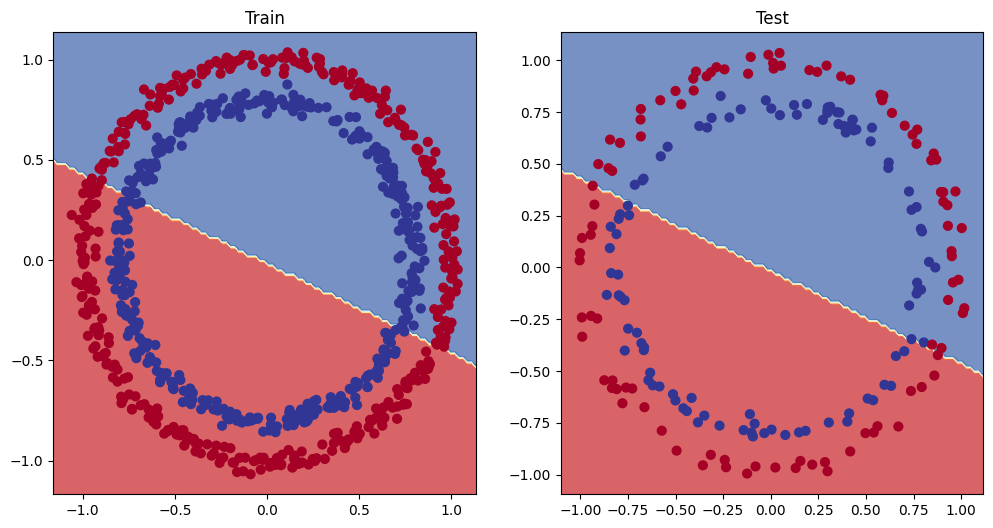

In [682]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # rows, cols, index
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

# Creating NEW CUSTOM MODEL

In [683]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=8)
        self.layer2 = nn.Linear(in_features=8, out_features=8)
        self.layer3 = nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [684]:
model1 = ModelV1().to(device)
model1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('layer1.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('layer2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.2767, -0.2512,  0.0223, -0.2413,  0.1090, -0.

In [685]:
set_seed = 42
torch.manual_seed(set_seed)
torch.cuda.manual_seed(set_seed)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model1.train()
    y_logits = model1(X_train).squeeze() # number -1 to 1
    y_preds = torch.round(torch.sigmoid(y_logits)) # 1 or 0 class


    # loss = nn.BCELoss()(torch.sigmoid(y_logits), y_train) # if using BCELoss()
    loss = loss_fn(y_logits, y_train) #BCEWithLogitsLoss()
    acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()
    loss.backward() # back propagation
    optimizer.step() # gradient descent

    # TESTING
    if(epoch % 100 == 0):
        model1.eval()
        with torch.inference_mode():
            test_logits = model1(X_test).squeeze()
            test_preds = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_preds)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 100 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 200 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 300 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 400 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 500 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 600 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 700 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 800 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%
Epoch: 900 | Loss: 0.69864, Acc: 47.62% | Test Loss: 0.69403, Test Acc: 51.00%


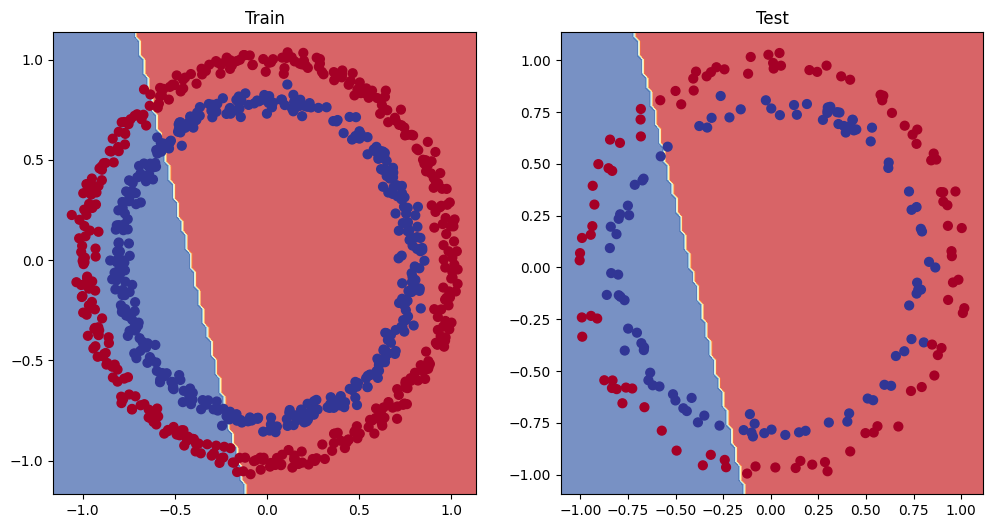

In [686]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # rows, cols, index
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

# SIDE PROJECT

In [687]:
model2 = nn.Sequential(nn.Linear(in_features=1, out_features=8), nn.Linear(in_features=8, out_features=1)).to(device)
model2

Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [688]:
# Creating data
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

train_split = int(0.8 * len(X_regression))
X_train, y_train = X_regression[:train_split], y_regression[:train_split]
X_test, y_test = X_regression[train_split:], y_regression[train_split:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([20, 1]))

In [689]:
# Optimizer and Loss fn
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.01)
loss_fn = nn.L1Loss()

In [690]:
epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model2.train()

    y_preds = model2(X_train)
    # loss = nn.BCELoss()(torch.sigmoid(y_logits), y_train) # if using BCELoss()
    loss = loss_fn(y_preds, y_train)
    # acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()
    loss.backward() # back propagation
    optimizer.step() # gradient descent

    # TESTING
    if(epoch % 100 == 0):
        model2.eval()
        with torch.inference_mode():
            test_preds = model2(X_test).squeeze()

            test_loss = loss_fn(test_preds, y_test)
            # test_acc = accuracy_fn(y_test, test_preds)

        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0 | Loss: 0.76834 | Test Loss: 0.76745
Epoch: 100 | Loss: 0.02032 | Test Loss: 0.04816
Epoch: 200 | Loss: 0.01752 | Test Loss: 0.04853
Epoch: 300 | Loss: 0.01576 | Test Loss: 0.04906
Epoch: 400 | Loss: 0.01296 | Test Loss: 0.05011
Epoch: 500 | Loss: 0.01119 | Test Loss: 0.05123
Epoch: 600 | Loss: 0.00840 | Test Loss: 0.05290
Epoch: 700 | Loss: 0.00561 | Test Loss: 0.05447
Epoch: 800 | Loss: 0.00383 | Test Loss: 0.05678
Epoch: 900 | Loss: 0.00204 | Test Loss: 0.05884


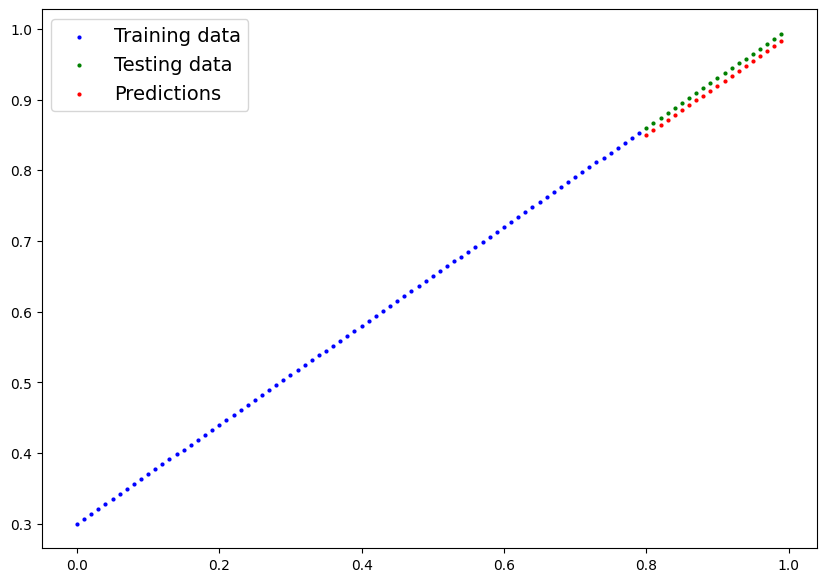

In [691]:
model2.eval()
with torch.inference_mode():
    y_preds = model2(X_test).squeeze()
    test_loss = loss_fn(y_preds, y_test)

plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

### So the model is actually learning, as it's able to fit for the linear line data. However, since the 2 circles are non-linear, we need to use another approach to allow it to learn for circles.

# The Missing Piece: Non-Linearity

## Recreating circles data

(np.float64(-1.1641631705326736),
 np.float64(1.1383724631691474),
 np.float64(-1.1729569179662098),
 np.float64(1.1411922753098467))

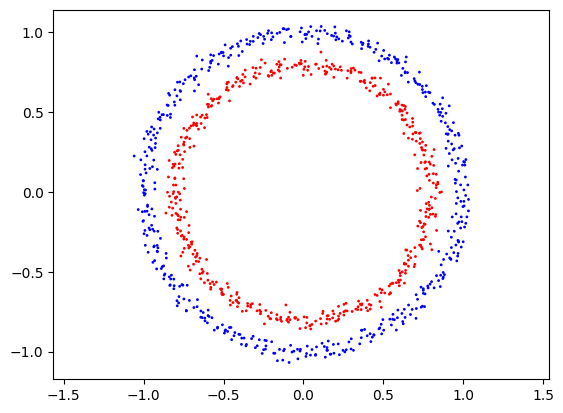

In [692]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

#create circles
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=1) # x, y, class, classColours, size of point
plt.axis('equal')

In [693]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
print("Turn numpy into float tensors \n", X[:5], y[:5])

Turn numpy into float tensors 
 tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) tensor([1., 1., 1., 1., 0.])


In [694]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Splitting data into training and testing \n", len(X_train), len(X_test), len(y_train), len(y_test))

Splitting data into training and testing 
 800 200 800 200


# NEW CUSTOM MODEL WITH NON-LINEARITY

In [695]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [696]:
model2 = ModelV2().to(device)
model2

ModelV2(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [697]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

In [698]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1500

for epoch in range(epochs):
    model2.train()
    y_logits = model2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(epoch % 100 == 0):
        model2.eval()
        with torch.inference_mode():
            test_logits = model2(X_test).squeeze()
            test_preds = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_preds)
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69263, Acc: 50.50% | Test Loss: 0.69240, Test Acc: 48.00%
Epoch: 100 | Loss: 0.68961, Acc: 56.50% | Test Loss: 0.69006, Test Acc: 52.50%
Epoch: 200 | Loss: 0.68658, Acc: 62.50% | Test Loss: 0.68726, Test Acc: 65.00%
Epoch: 300 | Loss: 0.68110, Acc: 67.25% | Test Loss: 0.68216, Test Acc: 65.50%
Epoch: 400 | Loss: 0.67121, Acc: 73.50% | Test Loss: 0.67281, Test Acc: 72.50%
Epoch: 500 | Loss: 0.65449, Acc: 81.00% | Test Loss: 0.65678, Test Acc: 80.50%
Epoch: 600 | Loss: 0.62287, Acc: 86.38% | Test Loss: 0.62561, Test Acc: 86.00%
Epoch: 700 | Loss: 0.56127, Acc: 93.25% | Test Loss: 0.56600, Test Acc: 92.50%
Epoch: 800 | Loss: 0.45121, Acc: 99.12% | Test Loss: 0.46475, Test Acc: 97.00%
Epoch: 900 | Loss: 0.36581, Acc: 87.75% | Test Loss: 0.38576, Test Acc: 89.00%
Epoch: 1000 | Loss: 0.36235, Acc: 78.12% | Test Loss: 0.39616, Test Acc: 78.50%
Epoch: 1100 | Loss: 0.30196, Acc: 86.12% | Test Loss: 0.34655, Test Acc: 83.00%
Epoch: 1200 | Loss: 0.09607, Acc: 100.00% | Test Los

## Evaluating Results using Non-Linear Model

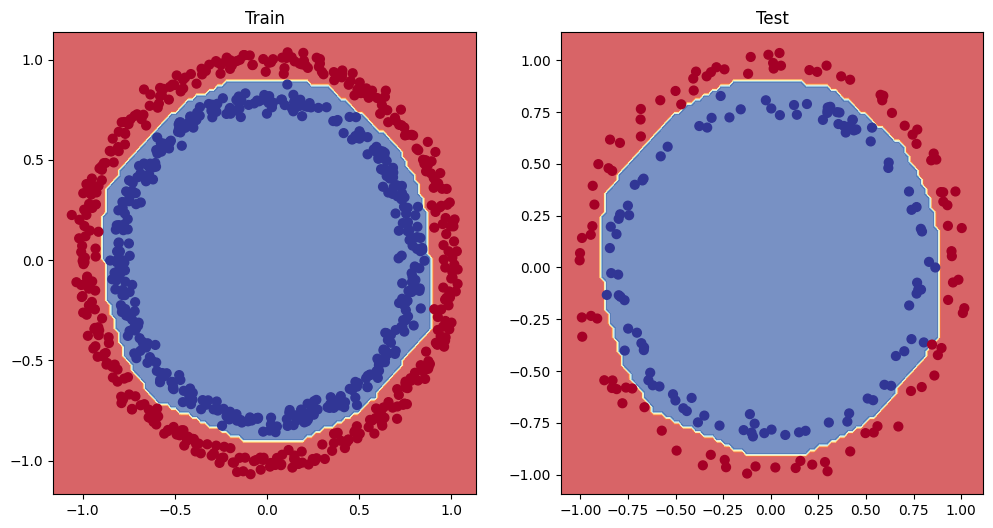

In [699]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # rows, cols, index
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)

# Multi-Class

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


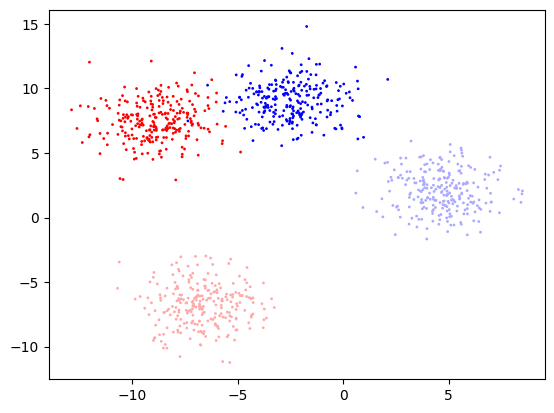

In [700]:
# Setting up & Data Creation
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device = "cude" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 4
NUM_FEATURES = 2
seed = 42
X_blobs, y_blobs = make_blobs(n_samples=1000,
                               n_features=NUM_FEATURES, # x and y
                               centers=NUM_CLASSES, # num of centers
                               cluster_std=1.5, # deviation of the clusters, higher more noisy
                               random_state=seed)

X_blobs = torch.from_numpy(X_blobs).float()
y_blobs = torch.from_numpy(y_blobs).long() # need int64 for crossentropyloss
print(X_blobs[:5], y_blobs[:5])
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs,cmap='bwr', s=1)

In [701]:
X_train, X_test, y_train, y_test = train_test_split(X_blobs, y_blobs, test_size=0.2, random_state=seed)
X_train

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]])

In [702]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [703]:
model3 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)
model3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [704]:
# Loss fn and Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model3.parameters(), lr=0.1)

In [705]:
# Before training logits
model3.eval()
with torch.inference_mode():
    y_logits = model3(X_test.to(device)).squeeze()
y_logits[:5]

tensor([[-0.0558,  0.8537,  0.0144, -0.1691],
        [-0.0585,  0.0856,  0.1203,  0.0969],
        [-0.4336,  0.2653, -0.5612,  1.4724],
        [ 0.0417,  0.6103, -0.0748, -0.2133],
        [-0.2403,  0.8179,  0.1363, -0.1530]])

### Logits(raw data) -> Probs(softmax) -> Prediction(argmax)

In [706]:
# Convert Logits into Prediction or probability (similar to sigmoid in binary class)
# sigmoid: 1 / 1+e^-x, range: 0 to 1
# softmax: e^xi / sum(e^x), range: 0 to 1, sum of all xi probs is 1
y_preds_prob = torch.softmax(y_logits, dim=1) # using dim=1 for row normalization, 0 for column
y_preds_prob[:5]

tensor([[0.1835, 0.4557, 0.1969, 0.1639],
        [0.2213, 0.2556, 0.2646, 0.2585],
        [0.0942, 0.1894, 0.0829, 0.6335],
        [0.2257, 0.3985, 0.2009, 0.1749],
        [0.1555, 0.4481, 0.2266, 0.1697]])

In [707]:
# convert prob to class
# torch.argmax: finds index of largest value in axis
y_preds = torch.argmax(y_preds_prob, dim=1) # dim=1 is row
y_preds[:5]

tensor([1, 2, 3, 1, 1])

In [708]:
# Training
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model3.train()
    y_logits = model3(X_train).squeeze()
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(epoch % 100 == 0):
        model3.eval()
        with torch.inference_mode():
            test_logits = model3(X_test).squeeze()
            test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_preds)

            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.56603, Acc: 38.25% | Test Loss: 1.36972, Test Acc: 38.50%
Epoch: 100 | Loss: 0.03852, Acc: 99.25% | Test Loss: 0.02850, Test Acc: 99.50%
Epoch: 200 | Loss: 0.02710, Acc: 99.25% | Test Loss: 0.01704, Test Acc: 99.50%
Epoch: 300 | Loss: 0.02493, Acc: 99.25% | Test Loss: 0.01453, Test Acc: 99.50%
Epoch: 400 | Loss: 0.02392, Acc: 99.25% | Test Loss: 0.01330, Test Acc: 99.50%
Epoch: 500 | Loss: 0.02327, Acc: 99.25% | Test Loss: 0.01255, Test Acc: 99.50%
Epoch: 600 | Loss: 0.02277, Acc: 99.25% | Test Loss: 0.01201, Test Acc: 99.50%
Epoch: 700 | Loss: 0.02237, Acc: 99.25% | Test Loss: 0.01157, Test Acc: 99.50%
Epoch: 800 | Loss: 0.02202, Acc: 99.25% | Test Loss: 0.01119, Test Acc: 99.50%
Epoch: 900 | Loss: 0.02170, Acc: 99.25% | Test Loss: 0.01086, Test Acc: 99.50%


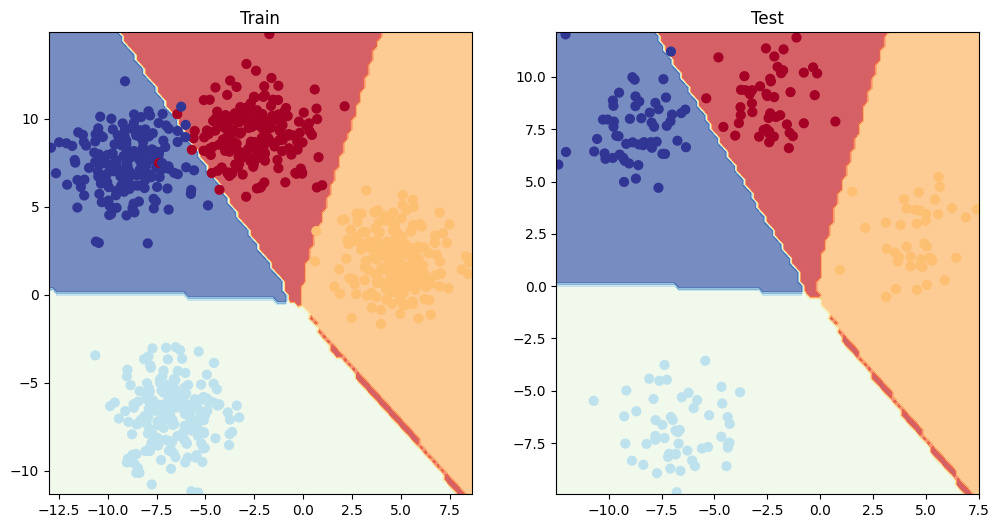

In [709]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # rows, cols, index
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)